In [1]:
!pip install --quiet bitsandbytes==0.41.1 transformers==4.39.3 accelerate==0.24.0 sentencepiece==0.1.99 optimum==1.13.2 auto-gptq==0.4.2 torchmetrics datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.0/301.0 kB 12.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 88.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.0/261.0 kB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 72.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 866.2/866.2 kB 46.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 32.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 91.8 MB/s e

In [2]:
import gc
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import transformers
import bitsandbytes as bnb
import subprocess
import os
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
from torch.utils.data import DataLoader
from tqdm.auto import tqdm, trange
from IPython.display import clear_output
from random import sample
from tqdm import tqdm
from torchmetrics.functional import accuracy
from torch.optim import AdamW
from peft import PromptTuningConfig, PromptTuningInit, get_peft_model, LoraConfig, TaskType
from transformers import AutoTokenizer, AutoModelForSequenceClassification, BitsAndBytesConfig

sns.set_theme()

os.environ['TOKENIZERS_PARALLELISM'] = 'false'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
!nvidia-smi

Mon Aug 26 21:01:15 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8              10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [4]:
train_dataset = load_dataset("glue", "sst2", split='train[:50000]')
valid_dataset = load_dataset("glue", "sst2", split="validation")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/67349 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/872 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1821 [00:00<?, ? examples/s]

In [5]:
train_dataset[0]

{'sentence': 'hide new secretions from the parental units ',
 'label': 0,
 'idx': 0}

In [6]:
model_checkpoint = "gpt2"

In [7]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
tokenizer.add_special_tokens({'pad_token': '[PAD]'})

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

1

In [8]:
class Model(nn.Module):
    def __init__(self, tokenizer, num_classes=2):
        super().__init__()
        self.model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_classes)
        self.model.resize_token_embeddings(len(tokenizer))
        self.config = self.model.config

    def forward(self, input_ids=None, attention_mask=None, inputs_embeds=None, *args, **kwargs):
        out = self.model.transformer(
            input_ids=input_ids, inputs_embeds=inputs_embeds, attention_mask=attention_mask
        ).last_hidden_state
        lens = attention_mask.sum(-1).cpu() - 1
        out = out[torch.arange(len(lens)), lens.to(torch.long)]
        return self.model.score(out)

    @property
    def device(self):
        return next(self.model.parameters()).device


num_classes = 2
model = Model(tokenizer, num_classes)

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
batch_size = 128
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size, num_workers=2)
valid_loader = DataLoader(valid_dataset, shuffle=False, batch_size=batch_size, num_workers=2)

In [10]:
def training_loop_fn(model, opt, total_num_iters, eval_freq, train_loader, valid_loader):
    train_loss_history, eval_loss_history = [], []
    train_acc_history, eval_acc_history = [], []
    global_step = 0

    criterion = torch.nn.CrossEntropyLoss()
    model.train()
    while True:
        for batch in tqdm(train_loader):
            tokenized = tokenizer(batch["sentence"], padding=True, return_tensors='pt')
            for k, v in tokenized.items():
                tokenized[k] = v.to(device)

            with torch.autocast(device_type='cuda', dtype=torch.float16):
                logits = model(tokenized['input_ids'], tokenized['attention_mask'], return_dict=False)
            targets = batch["label"].to(device)
            loss = criterion(logits, targets)

            opt.zero_grad()
            loss.backward()
            opt.step()

            preds = torch.nn.functional.softmax(logits, dim=-1)[:, 1]
            acc = accuracy(preds, targets, task="binary")

            train_loss_history.append((global_step, loss.item()))
            train_acc_history.append((global_step, acc.item()))

            if global_step % eval_freq == 0:
                val_loss, val_acc = evaluate(model, valid_loader)
                eval_loss_history.append((global_step, val_loss))
                eval_acc_history.append((global_step, val_acc))

                model.train()

            if global_step % 250 == 0:
                clear_output(True)

                plt.figure(figsize=(15, 5))

                plt.subplot(121)
                plt.plot(*zip(*train_loss_history), alpha=0.5, label='train_loss')
                if len(eval_loss_history):
                    plt.plot(*zip(*eval_loss_history), color='red', label='eval_loss')
                plt.legend()

                plt.subplot(122)
                plt.plot(*zip(*train_acc_history), alpha=0.5, label='train_acc')
                if len(eval_acc_history):
                    plt.plot(*zip(*eval_acc_history), color='red', label='eval_acc')
                plt.legend()
                plt.show()

            global_step += 1
            if global_step > total_num_iters:
                break
        else:
            continue
        break


@torch.no_grad()
def evaluate(model, dataloader):
    model.eval()
    criterion = torch.nn.CrossEntropyLoss()
    loss_epoch = 0.
    num_epoch = 0.
    preds_list = []
    targets_list = []

    for eval_batch in dataloader:
        tokenized = tokenizer(eval_batch["sentence"], padding=True, return_tensors='pt')
        for k, v in tokenized.items():
            tokenized[k] = v.to(device)

        with torch.autocast(device_type='cuda', dtype=torch.float16):
            logits = model(tokenized['input_ids'], tokenized['attention_mask'], return_dict=False)

        loss = criterion(logits, eval_batch["label"].to(device))
        num = logits.shape[0]

        loss_epoch += loss.item() * num
        num_epoch += num
        preds = torch.nn.functional.softmax(logits, dim=-1)[:, 1]

        targets_list += eval_batch["label"].tolist()
        preds_list += preds.tolist()

    acc = accuracy(torch.tensor(preds_list).to(device), torch.tensor(targets_list).to(device), task='binary')

    return loss_epoch / num_epoch, acc.item()

In [11]:
model = Model(tokenizer, num_classes).to(device)
optimizer = AdamW(model.parameters(), lr=2e-6)

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


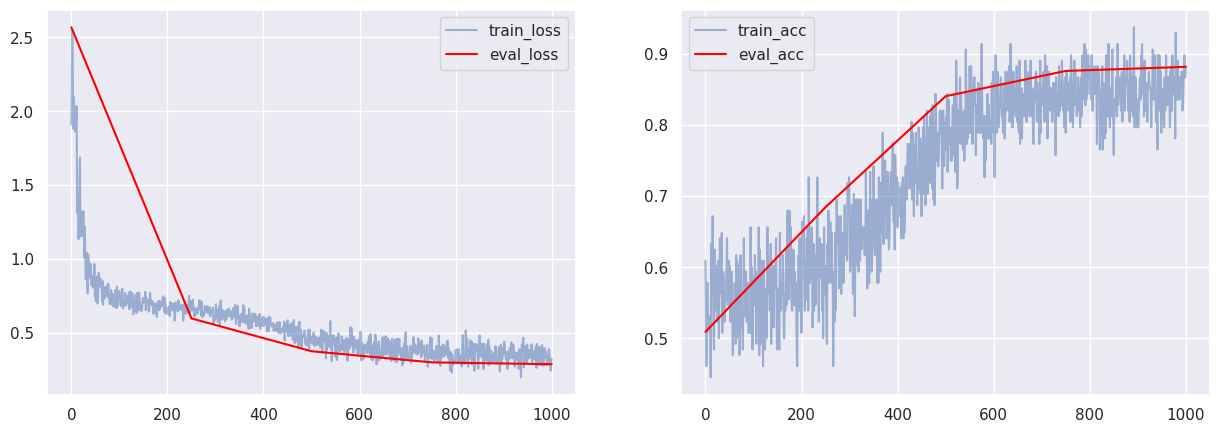

 56%|█████▌    | 218/391 [01:39<01:18,  2.19it/s]

CPU times: user 7min 1s, sys: 3.39 s, total: 7min 4s
Wall time: 7min 38s


In [12]:
%%time
training_loop_fn(model, optimizer, 1000, 250, train_loader, valid_loader)

In [13]:
val_loss, val_acc = evaluate(model, valid_loader)
print(f'val loss: {val_loss}')
print(f'val accuracy: {val_acc}')

val loss: 0.2899696280103211
val accuracy: 0.8818807601928711
